# edu-cater 

In [1]:
# imports

!pip install selenium
!pip install pyLDAvis
from selenium import webdriver
from bs4 import BeautifulSoup
import requests, os, json, csv, copy, operator
from collections import Counter

import pandas as pd
import numpy as np
import pickle, time
import seaborn as sns
from scipy.io import savemat, loadmat
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # ???
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from pyLDAvis import sklearn as pyldavis_sklearn

import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import jaccard
from gensim.matutils import jensen_shannon

from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import pyLDAvis
from pyLDAvis import gensim as pyldagensim

import networkx as nx
from networkx.algorithms import shortest_path

import warnings
warnings.filterwarnings('ignore')


# import edu-cater classes/functions
# from edutools import course_scraper

     |████████████████████████████████| 911kB 3.5MB/s 
     |████████████████████████████████| 1.6MB 3.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=9e91974eaaa5777e6acf9a0851c79e47372b26822e9a830aff78f6cca0c9afad
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Latent Dirichlet Allocation (LDA)

In [2]:
!wget https://raw.githubusercontent.com/amandakeasson/edu-cater/master/processed_info.pkl
file = open('processed_info.pkl', 'rb')
processed_info, skills_all, course_info_all = pickle.load(file)
file.close()

--2019-10-06 20:27:51--  https://raw.githubusercontent.com/amandakeasson/edu-cater/master/processed_info.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19035813 (18M) [application/octet-stream]
Saving to: ‘processed_info.pkl’

processed_info.pkl  100%[===================>]  18.15M   101MB/s    in 0.2s    

2019-10-06 20:27:51 (101 MB/s) - ‘processed_info.pkl’ saved [19035813/19035813]



In [5]:
stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
stopwords.extend(['youâ', 'week', 'write', 'solv', 'peer', 'assign', 'beginn',
                  'need', 'peopl', 'content', 'teach', 'assess', 'plan', 'capston',
                  'video', 'lesson', 'think', 'idea', 'lectur', 'learner',
                 'quiz', 'test', 'submit', 'way', 'good', 'choos', 'begin', 'examin', 'colleg', 'academ', 'university', 'mooc',
                 'teacher', 'educ', 'classroom', 'want', 'materi', 'instruct', 'level', 'section'])

# make dictionary
dictionary = gensim.corpora.Dictionary(processed_info)
print('Length of original dictionary:', len(dictionary))

# remove rare and common words
dictionary.filter_extremes(no_below=10, no_above=.25, keep_n=100000)
print('Length of filtered dictionary:', len(dictionary))

# make bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_info]

Length of original dictionary: 18820
Length of filtered dictionary: 3057


# testing with sklearn

In [0]:
countvec = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=.25, min_df=10)
clean_text = [' '.join(text) for text in processed_info]
X = countvec.fit_transform(clean_text).todense()

In [0]:
def get_jensen_shannon(components, ntopics):
    #topic_dists = lda_model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topic_dists = components 
    js_dists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i>j:
                js_dists.append(jensen_shannon(topic_dists[i,:], topic_dists[j,:]))
                
    return np.min(js_dists), np.mean(js_dists)

def get_jaccard(components, ntopics):
    topn = int(np.ceil(len(dictionary)*(10/100)))
    topic_word_probs = components #/ model.components_.sum(axis=1)[:, np.newaxis]
    top_terms = np.argsort(-1*topic_word_probs,axis=1)
    top_terms = -1*top_terms[:,0:topn]
    jdists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i > j:   
                jdists.append(jaccard(top_terms[i,:], top_terms[j,:]))
    return np.min(jdists), np.mean(jdists)

In [0]:
def avg_score(components, ntopics, ytrue=None):
    score1 = get_jensen_shannon(components, ntopics)[0]
    score2 = get_jaccard(components, ntopics)[0]
    return (score1 + score2)/2

In [0]:
class LDAwithCustomScore(LatentDirichletAllocation):
    def score(self, X, y=None):
        # You can change the options passed to perplexity here
        #score = avg_score(super(LDAwithCustomScore, self))
        components = self.components_
        ntopics = self.n_components
        score = get_jensen_shannon(components, ntopics)[0]
        return score
    

In [0]:
# grid search CV with pipeline

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Define Search Param
ntopics_list = [21, 22, 23, 24, 25]
ntopics_list = np.arange(10, 21)
search_params = {'n_components': ntopics_list}
lda = LDAwithCustomScore()

model = GridSearchCV(lda, param_grid=search_params, cv=10)
model.fit(X)

# Best Model
best_lda_model = model.best_estimator_

file = open('sklearn_model8.pkl', 'wb')
pickle.dump(model,file)
file.close()

In [0]:
from google.colab import files
files.download('sklearn_model8.pkl')

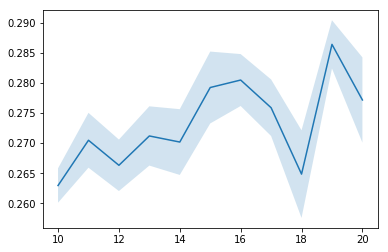

In [13]:


cvmean = model.cv_results_['mean_test_score']
cvstd = model.cv_results_['std_test_score']

plt.plot(ntopics_list, cvmean)
cvse = cvstd/np.sqrt(10)
plt.fill_between(ntopics_list, cvmean+cvse, cvmean-cvse,alpha=.2)